In [26]:
import numpy as np
import pandas as pd

train_df = pd.read_csv('HW4_train.csv')
test_df = pd.read_csv('HW4_future.csv')

# **Q1. Construct 95% prediction intervals for "price".**

### 1. Train conformal interval on train set

Importing packages and defining X,y

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


X = train_df.drop('price', axis=1)  # Features
y = train_df['price']  # Target variable

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data preprocessing and training the model

I will use Lasso regression for predicting future y

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Identifying numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Creating a column transformer with transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values in numeric columns with the mean
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values in categorical columns with 'missing'
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Creating a pipeline that includes preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=1.0))
])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)
error_pred = y_test - y_pred

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 20034.822457874456


In [29]:
# find the quantile for |prediction error|
q=np.quantile(np.abs(error_pred),0.95)
q

222.34799966092433

In [30]:
# construct prediction interval for future Y
lower_bound= pipeline.predict(X_test)-q # f(X)-q
upper_bound= pipeline.predict(X_test)+q # f(X)+q


In [31]:
# check the coverage probability
if_cover=(lower_bound<=y_test)*(y_test<=upper_bound)
np.mean(if_cover)

0.9499131145865276

In [32]:
# compute the width of the prediction interval
2*q

444.69599932184866

## 2. Apply this method on the test set

In [33]:
X = test_df.drop('price', axis=1)  # Features
y = test_df['price']  # Target variable

In [34]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Identifying numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Creating a column transformer with transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values in numeric columns with the mean
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values in categorical columns with 'missing'
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

In [36]:
y_future_pred = pipeline.predict(X)

In [37]:
# Construct prediction interval for future dataset
future_lower_bound = y_future_pred - q
future_upper_bound = y_future_pred + q

# Combine into a DataFrame
prediction_intervals = pd.DataFrame({
    'lower_bound': future_lower_bound,
    'upper_bound': future_upper_bound
})

# Save the DataFrame to a CSV file
prediction_intervals.to_csv('HW4_Q1.csv', index=False)

## **Q2. Question 2: suppose that you want to consider the effect of being instantly bookable ("instant_bookable" being "t") on "price". You are willing to assume that the unconfoundedness assumption holds once we include "city" and "accommodates" as confounders. At 5% significance level, can you say that being instantly bookable always has no effect on "price"?**
[15 points] Submit a Jupyter notebook with comments, supporting calculations (such as p-values) and the conclusion. Please use only "HW4_train.csv" for this question. (Hint: "HW4_future.csv" is not helpful for this question.)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('HW4_train.csv')

# Preprocessing: Convert 'instant_bookable' to numeric (t -> 1, f -> 0)
df['instant_bookable'] = df['instant_bookable'].map({'t': 1, 'f': 0})

# Keeping only the relevant columns
relevant_columns = df[['price', 'instant_bookable', 'city', 'accommodates']]

# Handling categorical variables ('city') using one-hot encoding
X = pd.get_dummies(relevant_columns.drop('price', axis=1), drop_first=True)
y = relevant_columns['price']

# Adding a constant for the intercept term for the OLS model
X = sm.add_constant(X)

# Splitting the data into training and testing sets for a more robust analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit an OLS model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the regression
model_summary = model.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     1972.
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        19:27:34   Log-Likelihood:            -2.5238e+05
No. Observations:               39129   AIC:                         5.048e+05
Df Residuals:                   39121   BIC:                         5.048e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               44.1133      3.809     11.582      0.000      36.648      51.578
instant_bookable   -19.4571      1.761    -11.052      0.000     -22.908     -16.006
accommodates        40.1117      0.359    111.848      0.000      39.409      40.815
city_Chicago       -56.0157      4.927    -11.369      0.000     -65.673     -46.358
city_DC             35.0376      4.537      7.723      0.000      26.146      43.929
city_LA            -17.6712      3.842     -4.599      0.000     -25.202     -10.141
city_NYC            -7.5297      3.768     -1.998      0.046     -14.916      -0.144
city_SF             60.2861      4.438     13.585      0.000      51.588      68.984
==============================================================================
Omnibus:                    37743.055   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2532374.763
Skew:                           4.616   Prob(JB):                         0.00
Kurtosis:                      41.315   Cond. No.                         46.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the result above, the coefficient for "instant_bookable" is -19.4571 with a p-value close to 0. This shows that the variable "instant_bookable" is statistically significant at 5% significance level.

We can reject the null hypothesis that being instantly bookable has no effect on the price. The negative coefficient of -19.4571 suggests that it has a significant negative effect on the price.

## **Q3. suppose that you want to consider the effect of being instantly bookable ("instant_bookable" being "t") on "price". You are willing to assume that the unconfoundedness assumption holds once we include enough confounders. For confounders, use "bathrooms", "accommodates" and "cancellation_policy".**
[15 points] Submit a Jupyter notebook that does the following. (1) Use K-NN to build a model for conditional average treatment effect (CATE). (2) For each of the three confounders, make a scatter plot of CATE against this confounder. (Hint: "HW4_future.csv" is not helpful for this question.)

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

df = pd.read_csv('HW4_train.csv')

Data preprocessing and defining new variables

In [19]:
# Convert 'instant_bookable' to numeric (t -> 1, f -> 0)
df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)

# Removing rows with NAN values in 'bathrooms', 'accommodates'
df.dropna(subset=['bathrooms', 'accommodates'], inplace=True)

# Handling categorical variables ('cancellation_policy) using one-hot encoding
df = pd.get_dummies(df, columns=['cancellation_policy'], drop_first=True)

# Define the treatment variable
treatment = df['instant_bookable']

# Define the outcome variable
outcome = df['price']

# Define confounders
# Since I used one-hot encoding, get columns starting with 'cancellation_policy_'
confounders = df[['bathrooms', 'accommodates'] + [col for col in df.columns if col.startswith('cancellation_policy_')]]


Using KNN to predict CATE

In [20]:
# Split the dataset into treated and control groups
treated_df = df[df['instant_bookable'] == 1]
control_df = df[df['instant_bookable'] == 0]

# Function to estimate CATE using K-NN
def estimate_cate(X, treatment, outcome, n_neighbors=5):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(X, outcome, treatment, test_size=0.2, random_state=42)

    # K-NN regressor for treated and control
    knn_treated = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_control = KNeighborsRegressor(n_neighbors=n_neighbors)

    # Fit the models
    knn_treated.fit(X_train[treatment_train == 1], y_train[treatment_train == 1])
    knn_control.fit(X_train[treatment_train == 0], y_train[treatment_train == 0])

    # Predict outcomes
    y_pred_treated = knn_treated.predict(X_test)
    y_pred_control = knn_control.predict(X_test)

    # Estimate CATE
    cate_estimates = y_pred_treated - y_pred_control
    return X_test, cate_estimates

# Estimate CATE
X_test, cate_estimates = estimate_cate(confounders, treatment, outcome, n_neighbors=5)


Make a scatterplot

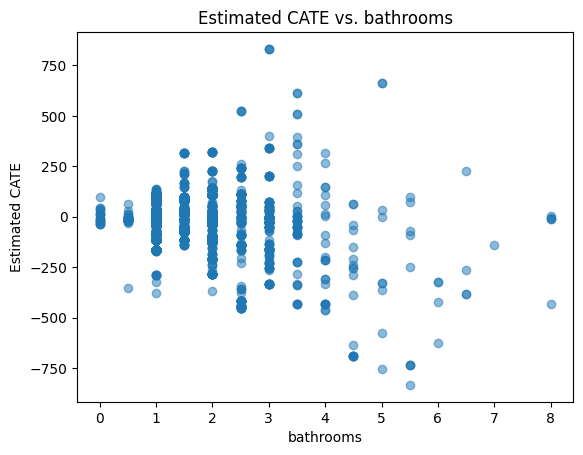

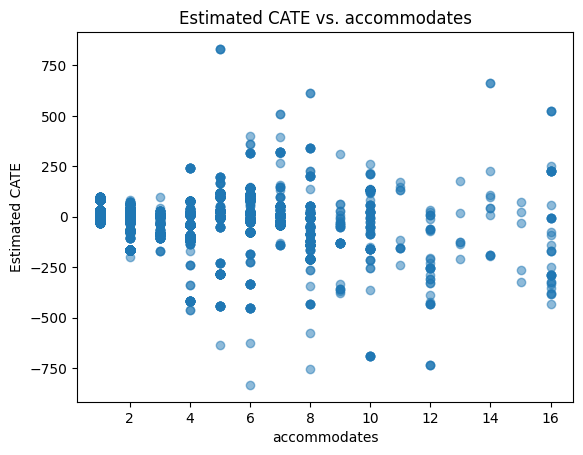

In [21]:
# Function to plot CATE against a confounder
def plot_cate_against_confounder(X_test, cate_estimates, confounder_name):
    plt.scatter(X_test[confounder_name], cate_estimates, alpha=0.5)
    plt.xlabel(confounder_name)
    plt.ylabel('Estimated CATE')
    plt.title(f'Estimated CATE vs. {confounder_name}')
    plt.show()

# Plot CATE against each confounder
for confounder in ['bathrooms', 'accommodates']:
    plot_cate_against_confounder(X_test, cate_estimates, confounder)